In [1]:
%ls

Dockerfile                    results_check.byte
__pycache__/                  runner.sh
checker_client.py             solution.py
env.yaml                      test_xs.npz
euler-guide.md                test_ys.bytes
examples_least_confident.pdf  train.ipynb
examples_most_confident.pdf   train_xs.npz
main.ipynb                    train_ys.npz
map_weights.pt                util.py
pytransform/                  val_xs.npz
reliability_diagram.pdf       val_ys.npz
requirements.txt


In [2]:
from solution import *

In [3]:

data_dir = pathlib.Path.cwd()
model_dir = pathlib.Path.cwd()
output_dir = pathlib.Path.cwd()

# Load training data
train_xs = torch.from_numpy(np.load(data_dir / "train_xs.npz")["train_xs"])
raw_train_meta = np.load(data_dir / "train_ys.npz")
train_ys = torch.from_numpy(raw_train_meta["train_ys"])
train_is_snow = torch.from_numpy(raw_train_meta["train_is_snow"])
train_is_cloud = torch.from_numpy(raw_train_meta["train_is_cloud"])
dataset_train = torch.utils.data.TensorDataset(train_xs, train_is_snow, train_is_cloud, train_ys)

# Load validation data
val_xs = torch.from_numpy(np.load(data_dir / "val_xs.npz")["val_xs"])
raw_val_meta = np.load(data_dir / "val_ys.npz")
val_ys = torch.from_numpy(raw_val_meta["val_ys"])
val_is_snow = torch.from_numpy(raw_val_meta["val_is_snow"])
val_is_cloud = torch.from_numpy(raw_val_meta["val_is_cloud"])
dataset_val = torch.utils.data.TensorDataset(val_xs, val_is_snow, val_is_cloud, val_ys)


In [6]:
# Fix all randomness
setup_seeds()

# Build and run the actual solution
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)
swag = SWAGInference(
    train_xs=dataset_train.tensors[0],
    model_dir=model_dir,
    swag_epochs=30,
    deviation_matrix_max_rank=15,
)

In [7]:
swag.fit(train_loader)

Loaded pretrained MAP weights from /Users/alpayozkan/eth/pai_proj/task2_handout_e14a_works_for_new_mac/map_weights.pt


Running gradient descent for SWA: 100%|█| 30/30 [09:00<00:00, 18.03s/it, lr


In [14]:
swag.calibrate(dataset_val)

In [9]:

eval_dataset = dataset_val
extended_evaluation = EXTENDED_EVALUATION
output_dir = output_dir

In [37]:
# We ignore is_snow and is_cloud here, but feel free to use them as well
xs, is_snow, is_cloud, ys = dataset_train.tensors

# Predict class probabilities on test data,
# most likely classes (according to the max predicted probability),
# and classes as predicted by your SWAG implementation.
train_pred_prob_all = swag.predict_probabilities(xs)
train_pred_prob_max, pred_ys_argmax = torch.max(train_pred_prob_all, dim=-1)
train_pred_ys = swag.predict_labels(train_pred_prob_all)

Performing Bayesian model averaging: 100%|█| 30/30 [05:45<00:00, 11.51s/it]


In [10]:
# We ignore is_snow and is_cloud here, but feel free to use them as well
xs, is_snow, is_cloud, ys = eval_dataset.tensors

# Predict class probabilities on test data,
# most likely classes (according to the max predicted probability),
# and classes as predicted by your SWAG implementation.
pred_prob_all = swag.predict_probabilities(xs)
pred_prob_max, pred_ys_argmax = torch.max(pred_prob_all, dim=-1)
pred_ys = swag.predict_labels(pred_prob_all)

Performing Bayesian model averaging:   0%|          | 0/30 [00:00<?, ?it/s]/Users/alpayozkan/eth/pai_proj/task2_handout_e14a_works_for_new_mac/solution.py:374: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  sampled_param += 1/torch.sqrt(torch.tensor(2) * (self.deviation_matrix_max_rank-1)) * torch.matmul(Dparam.T, z_2).T
Performing Bayesian model averaging: 100%|█| 30/30 [03:12<00:00,  6.42s/it]


TypeError: '>=' not supported between instances of 'Tensor' and 'NoneType'

In [13]:
pred_prob_all.shape

torch.Size([140, 6])

In [16]:
pred_ys

tensor([-1, -1,  3,  2,  1, -1, -1,  4, -1, -1,  0, -1,  5, -1,  5,  1,  3, -1,
         0, -1, -1, -1, -1, -1,  3, -1,  0,  1,  5, -1, -1,  4,  0,  5, -1,  3,
        -1, -1,  5,  1, -1,  4,  3,  0, -1, -1, -1,  3, -1,  5,  1, -1, -1,  4,
         1, -1, -1,  2,  3,  0, -1, -1,  3,  1, -1, -1, -1, -1, -1,  1,  0, -1,
         4, -1, -1,  5,  5,  3, -1,  5,  4,  1,  5, -1, -1,  3,  0,  4,  0, -1,
        -1, -1, -1,  2,  5,  4,  3,  5, -1,  3, -1,  0,  3,  1,  0, -1,  4, -1,
         1,  3,  0,  5, -1,  4, -1,  0, -1,  4, -1, -1,  0, -1,  4, -1,  3, -1,
        -1, -1, -1,  5, -1, -1, -1,  0,  3, -1, -1,  5, -1,  0])

(array([67., 16., 11.,  3., 16., 12., 15.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <BarContainer object of 7 artists>)

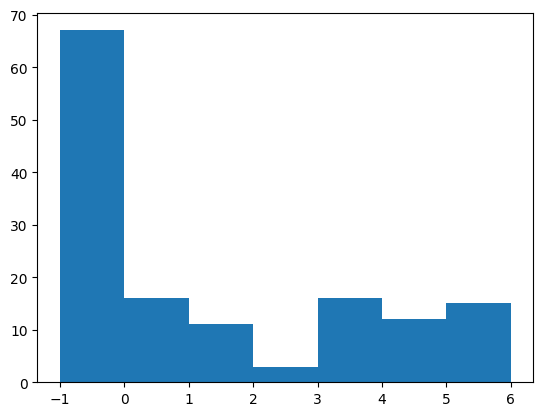

In [21]:
counts, bins = np.histogram(pred_ys, bins=[-1,0,1,2,3,4,5,6])
plt.hist(bins[:-1], bins, weights=counts)

(array([ 0., 22., 17., 39., 21., 19., 22.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <BarContainer object of 7 artists>)

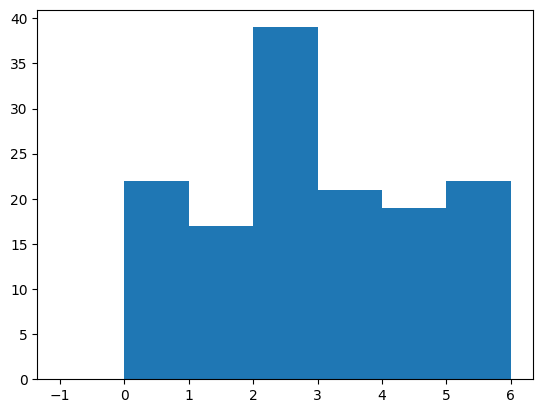

In [22]:
counts, bins = np.histogram(pred_ys_argmax, bins=[-1,0,1,2,3,4,5,6])
plt.hist(bins[:-1], bins, weights=counts)

In [18]:
train_xs = torch.from_numpy(np.load(data_dir / "train_xs.npz")["train_xs"])
raw_train_meta = np.load(data_dir / "train_ys.npz")
train_ys = torch.from_numpy(raw_train_meta["train_ys"])
train_is_snow = torch.from_numpy(raw_train_meta["train_is_snow"])
train_is_cloud = torch.from_numpy(raw_train_meta["train_is_cloud"])
dataset_train = torch.utils.data.TensorDataset(train_xs, train_is_snow, train_is_cloud, train_ys)

array([4, 0, 4, ..., 2, 3, 4])

In [ ]:


# Create a mask that ignores ambiguous samples (those with class -1)
nonambiguous_mask = ys != -1

# Calculate three kinds of accuracy:
# 1. Overall accuracy, counting "don't know" (-1) as its own class
# 2. Accuracy on all samples that have a known label. Predicting -1 on those counts as wrong here.
# 3. Accuracy on all samples that have a known label w.r.t. the class with the highest predicted probability.
accuracy = torch.mean((pred_ys == ys).float()).item()
accuracy_nonambiguous = torch.mean((pred_ys[nonambiguous_mask] == ys[nonambiguous_mask]).float()).item()
accuracy_nonambiguous_argmax = torch.mean(
    (pred_ys_argmax[nonambiguous_mask] == ys[nonambiguous_mask]).float()
).item()
print(f"Accuracy (raw): {accuracy:.4f}")
print(f"Accuracy (non-ambiguous only, your predictions): {accuracy_nonambiguous:.4f}")
print(f"Accuracy (non-ambiguous only, predicting most-likely class): {accuracy_nonambiguous_argmax:.4f}")

# Determine which threshold would yield the smallest cost on the validation data
# Note that this threshold does not necessarily generalize to the test set!
# However, it can help you judge your method's calibration.
thresholds = [0.0] + list(torch.unique(pred_prob_max, sorted=True))
costs = []
for threshold in thresholds:
    thresholded_ys = torch.where(pred_prob_max <= threshold, -1 * torch.ones_like(pred_ys), pred_ys)
    costs.append(cost_function(thresholded_ys, ys).item())
best_idx = np.argmin(costs)
print(f"Best cost {costs[best_idx]} at threshold {thresholds[best_idx]}")
print("Note that this threshold does not necessarily generalize to the test set!")

# Calculate ECE and plot the calibration curve
calibration_data = calc_calibration_curve(pred_prob_all.numpy(), ys.numpy(), num_bins=20)
print("Validation ECE:", calibration_data["ece"])

if extended_evaluation:
    print("Plotting reliability diagram")
    fig = draw_reliability_diagram(calibration_data)
    fig.savefig(output_dir / "reliability_diagram.pdf")

    sorted_confidence_indices = torch.argsort(pred_prob_max)

    # Plot samples your model is most confident about
    print("Plotting most confident validation set predictions")
    most_confident_indices = sorted_confidence_indices[-10:]
    fig, ax = plt.subplots(4, 5, figsize=(13, 11))
    for row in range(0, 4, 2):
        for col in range(5):
            sample_idx = most_confident_indices[5 * row // 2 + col]
            ax[row, col].imshow(xs[sample_idx].permute(1, 2, 0).numpy())
            ax[row, col].set_axis_off()
            ax[row + 1, col].set_title(f"pred. {pred_ys[sample_idx]}, true {ys[sample_idx]}")
            bar_colors = ["C0"] * 6
            if ys[sample_idx] >= 0:
                bar_colors[ys[sample_idx]] = "C1"
            ax[row + 1, col].bar(
                np.arange(6), pred_prob_all[sample_idx].numpy(), tick_label=np.arange(6), color=bar_colors
            )
    fig.suptitle("Most confident predictions", size=20)
    fig.savefig(output_dir / "examples_most_confident.pdf")

    # Plot samples your model is least confident about
    print("Plotting least confident validation set predictions")
    least_confident_indices = sorted_confidence_indices[:10]
    fig, ax = plt.subplots(4, 5, figsize=(13, 11))
    for row in range(0, 4, 2):
        for col in range(5):
            sample_idx = least_confident_indices[5 * row // 2 + col]
            ax[row, col].imshow(xs[sample_idx].permute(1, 2, 0).numpy())
            ax[row, col].set_axis_off()
            ax[row + 1, col].set_title(f"pred. {pred_ys[sample_idx]}, true {ys[sample_idx]}")
            bar_colors = ["C0"] * 6
            if ys[sample_idx] >= 0:
                bar_colors[ys[sample_idx]] = "C1"
            ax[row + 1, col].bar(
                np.arange(6), pred_prob_all[sample_idx].numpy(), tick_label=np.arange(6), color=bar_colors
            )
    fig.suptitle("Least confident predictions", size=20)
    fig.savefig(output_dir / "examples_least_confident.pdf")

In [ ]:
swag.calibrate(dataset_val)

# fork_rng ensures that the evaluation does not change the rng state.
# That way, you should get exactly the same results even if you remove evaluation
# to save computational time when developing the task
# (as long as you ONLY use torch randomness, and not e.g. random or numpy.random).
with torch.random.fork_rng():
    evaluate(swag, dataset_val, EXTENDED_EVALUATION, output_dir)